<a href="https://colab.research.google.com/github/Kushal94gitgit/Research-project/blob/main/Researchinbandgap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Imports
import numpy as np
import pandas as pd
import math, re
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import joblib
import warnings
warnings.filterwarnings('ignore')

# For Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

#tree model
import xgboost as xgb


In [3]:

data_path = "/content/results processed.xlsx"

#load
df = pd.read_excel(data_path)
print("Loaded shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())


Loaded shape: (10000, 18)
Columns: ['Sr.No.', 'material_id', 'formula_pretty', 'band_gap', 'energy_above_hull', 'formation_energy_per_atom', 'predicted_formation_energy_per_atom', 'density', 'volume', 'nsites', 'Elements', 'lattice_a', 'lattice_b', 'lattice_c', 'lattice_alpha', 'lattice_beta', 'lattice_gamma', 'lattice_matrix_str']


,Sr.No.,material_id,formula_pretty,band_gap,energy_above_hull,formation_energy_per_atom,predicted_formation_energy_per_atom,density,volume,nsites,Elements,lattice_a,lattice_b,lattice_c,lattice_alpha,lattice_beta,lattice_gamma,lattice_matrix_str
0,1,mp-8566,Ag,0.0000,0.000000,0.000000,NaN,10.315418,69.456950,4,Ag,2.911132,2.911131,9.463709,90.000000,90.000000,119.999983,"2.911131789999999,2e-08,0.0,-1.45556486,2.5211..."
1,2,mp-18125,Ag(AuF4)2,0.2585,0.000000,-1.201868,NaN,6.941567,312.794323,22,"Ag, Au, F",10.975638,5.175432,7.207008,49.823435,90.000000,90.000000,"10.97563797,0.0,0.0,0.0,5.17482764,-0.07911927..."
2,3,mp-35835,Ag(AuS)2,0.0000,0.051189,-0.060645,NaN,8.073054,232.811794,10,"Ag, Au, S",4.454032,7.172518,7.288495,89.064508,90.000000,90.000000,"4.454032,0.0,0.0,0.0,7.172518,0.0,0.0,0.118996..."
3,4,mp-567334,Ag(BCl)6,2.7028,0.000000,-0.736951,NaN,2.666186,1920.521818,104,"Ag, B, Cl",12.430056,12.430056,12.430056,90.000000,90.000000,90.000000,"12.4300559,-0.0,-0.0,0.0,12.4300559,-0.0,0.0,-..."
4,5,mp-558796,Ag(Bi2S3)3,0.0000,0.029380,-0.359322,NaN,6.530572,419.633518,16,"Ag, Bi, S",7.186057,7.186057,15.077771,81.173702,81.173702,33.092625,"2.046519,6.888481,0.0,-2.046519,6.888481,0.0,0..."


In [4]:
# This cell:
# - finds a plausible 'bandgap' column (searches for 'band'/'gap' in column names)
# - creates simple composition-derived features if a 'formula' column exists (avg atomic number etc.)
# - keeps numeric columns as candidate features

# 1) detect plausible bandgap column
candidate_targets = [c for c in df.columns if re.search(r'band|gap|eg', c, flags=re.I)]
if len(candidate_targets) == 0:
    raise ValueError("No column with 'band'/'gap' found. Rename your bandgap column (e.g. 'band_gap') or tell me the column name.")
target = candidate_targets[0]
print("Using target column:", target)
df[target] = pd.to_numeric(df[target], errors='coerce')

# 2) numeric candidate features (we'll refine these later)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c != target and not re.search(r'id|index', c, flags=re.I)]
print("Numeric candidate columns (sample):", num_cols[:10])

# 3) composition parsing (very simple parser) - if you have a formula/composition column
formula_col = None
for c in df.columns:
    if re.search(r'formula|composition|comp', c, flags=re.I):
        formula_col = c
        break
print("Detected formula/composition column:", formula_col)

# Periodic table symbols to atomic numbers (1..118)
element_symbols = [
 'H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca',
 'Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr',
 'Nb','Mo','Tc','Ru','Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd',
 'Pm','Sm','Eu','Gd','Tb','Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg',
 'Tl','Pb','Bi','Po','At','Rn','Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm',
 'Md','No','Lr','Rf','Db','Sg','Bh','Hs','Mt','Ds','Rg','Cn','Nh','Fl','Mc','Lv','Ts','Og'
]
periodic_table = {sym: i+1 for i, sym in enumerate(element_symbols)}

def parse_formula(formula):
    """
    Very simple formula parser (no parentheses support).
    E.g., Fe2O3 -> {'Fe':2.0, 'O':3.0}
    """
    if not isinstance(formula, str):
        return {}
    parts = re.findall(r'([A-Z][a-z]?)(\d*\.?\d*)', formula)
    counts = {}
    for el, cnt in parts:
        n = float(cnt) if cnt else 1.0
        counts[el] = counts.get(el, 0.0) + n
    return counts

comp_features = []
if formula_col is not None:
    df['_parsed'] = df[formula_col].apply(parse_formula)
    def comp_stats(d):
        if not d:
            return pd.Series({'num_elements':0, 'total_atoms':0, 'avg_atno':np.nan, 'max_atno':np.nan, 'min_atno':np.nan})
        total = sum(d.values())
        nums = []
        for el, cnt in d.items():
            atno = periodic_table.get(el, np.nan)
            if not math.isnan(atno):
                # weight by (rounded) counts for simplicity
                nums.extend([atno]*int(max(1, round(cnt))))
        avg = np.nan if len(nums)==0 else float(np.mean(nums))
        mx  = np.nan if len(nums)==0 else float(np.max(nums))
        mn  = np.nan if len(nums)==0 else float(np.min(nums))
        return pd.Series({'num_elements':len(d), 'total_atoms':total, 'avg_atno':avg, 'max_atno':mx, 'min_atno':mn})
    comp_df = df['_parsed'].apply(comp_stats)
    df = pd.concat([df, comp_df], axis=1)
    comp_features = ['num_elements','total_atoms','avg_atno','max_atno','min_atno']
    display(df[comp_features].head())
else:
    print("No formula column - composition features skipped.")


Using target column: band_gap
Numeric candidate columns (sample): ['Sr.No.', 'energy_above_hull', 'formation_energy_per_atom', 'predicted_formation_energy_per_atom', 'density', 'volume', 'nsites', 'lattice_a', 'lattice_b', 'lattice_c']
Detected formula/composition column: formula_pretty


,num_elements,total_atoms,avg_atno,max_atno,min_atno
0,1.0,1.0,47.000000,47.0,47.0
1,3.0,6.0,27.000000,79.0,9.0
2,3.0,3.0,47.333333,79.0,16.0
3,3.0,3.0,23.000000,47.0,5.0
4,3.0,6.0,43.500000,83.0,16.0


In [5]:
# Build feature set: numeric candidates + composition features (if any)
features = list(num_cols) + comp_features
features = [f for f in features if f in df.columns]
print("Initial features found:", features[:20])

# Keep rows with valid target and plausible bandgap range (0-20 eV)
df_model = df.dropna(subset=[target]).copy()
df_model = df_model[(df_model[target] >= 0) & (df_model[target] <= 20)]
print("Rows with valid target:", len(df_model))

# Drop features that are entirely NaN or constant (no variance)
valid_features = []
for f in features:
    non_null = df_model[f].dropna()
    if len(non_null) == 0:
        continue
    if non_null.nunique() <= 1:
        continue
    valid_features.append(f)

# Fallback: if no valid_features, use all numeric columns except target
if len(valid_features) == 0:
    cand = [c for c in df.select_dtypes(include=[np.number]).columns if c!=target]
    valid_features = [c for c in cand if df_model[c].dropna().nunique()>1]

print("Selected final features (sample):", valid_features[:30])

# Force numeric and fill remaining NaNs with median (if a column's median is NaN, fill with 0)
for f in valid_features:
    df_model[f] = pd.to_numeric(df_model[f], errors='coerce')
    if df_model[f].isnull().any():
        med = df_model[f].median()
        if np.isnan(med):
            med = 0.0
        df_model[f] = df_model[f].fillna(med)

# Confirm no NaNs remain in feature matrix
print("Total NaNs in selected features after filling:", df_model[valid_features].isnull().sum().sum())

# Prepare X, y arrays
X = df_model[valid_features].values.astype(float)
y = df_model[target].values.astype(float)
print("Final dataset shape X,y:", X.shape, y.shape)


Initial features found: ['Sr.No.', 'energy_above_hull', 'formation_energy_per_atom', 'predicted_formation_energy_per_atom', 'density', 'volume', 'nsites', 'lattice_a', 'lattice_b', 'lattice_c', 'lattice_alpha', 'lattice_beta', 'lattice_gamma', 'num_elements', 'total_atoms', 'avg_atno', 'max_atno', 'min_atno']
Rows with valid target: 10000
Selected final features (sample): ['Sr.No.', 'energy_above_hull', 'formation_energy_per_atom', 'density', 'volume', 'nsites', 'lattice_a', 'lattice_b', 'lattice_c', 'lattice_alpha', 'lattice_beta', 'lattice_gamma', 'num_elements', 'total_atoms', 'avg_atno', 'max_atno', 'min_atno']
Total NaNs in selected features after filling: 0
Final dataset shape X,y: (10000, 17) (10000,)


Train / val / test sizes: 7000 1500 1500
Iteration 1, loss = 1.67204572
Validation score: 0.175334
Iteration 2, loss = 0.86456256
Validation score: 0.445633
Iteration 3, loss = 0.67865078
Validation score: 0.510454
Iteration 4, loss = 0.60879621
Validation score: 0.538360
Iteration 5, loss = 0.57723211
Validation score: 0.547824
Iteration 6, loss = 0.55574509
Validation score: 0.552717
Iteration 7, loss = 0.53911843
Validation score: 0.561913
Iteration 8, loss = 0.52607022
Validation score: 0.567081
Iteration 9, loss = 0.51614600
Validation score: 0.571480
Iteration 10, loss = 0.50672746
Validation score: 0.576573
Iteration 11, loss = 0.49297406
Validation score: 0.573771
Iteration 12, loss = 0.48765552
Validation score: 0.582798
Iteration 13, loss = 0.48113840
Validation score: 0.576603
Iteration 14, loss = 0.47111581
Validation score: 0.580536
Iteration 15, loss = 0.46146062
Validation score: 0.585132
Iteration 16, loss = 0.45327174
Validation score: 0.580446
Iteration 17, loss = 0.4

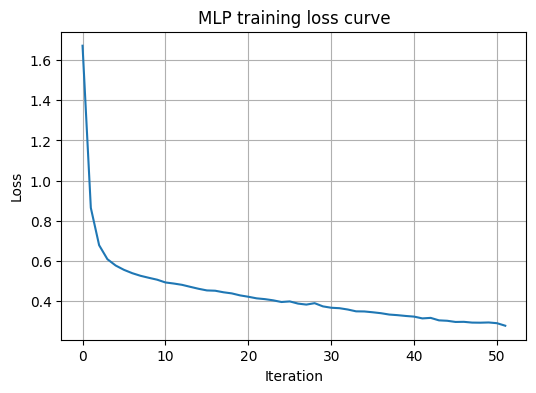

,true,pred
0,1.1087,0.354949
1,2.9678,2.210498
2,0.0000,2.598555
3,0.0157,0.921078
4,4.7924,3.405858
5,2.3680,2.105302
6,2.4024,1.209681
7,0.4475,0.195626
8,5.1877,4.500955
9,0.7729,0.262111


In [6]:
# Split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("Train / val / test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])

# Scale features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# Simple MLP using scikit-learn (fast for demo). Hidden layers chosen as a reasonable baseline.
mlp = MLPRegressor(
    hidden_layer_sizes=(128,64,32),
    activation='relu',
    solver='adam',
    learning_rate_init=1e-3,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=20,
    random_state=42,
    verbose=True
)

# Train
mlp.fit(X_train_s, y_train)

# Predict + evaluate
y_pred = mlp.predict(X_test_s)
mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
print(f"Test MAE: {mae:.4f} eV, RMSE: {rmse:.4f} eV, R2: {r2:.4f}")

# Save model & scaler
model_path = "bandgap_mlp.joblib"
scaler_path = "feature_scaler.joblib"
joblib.dump(mlp, model_path)
joblib.dump(scaler, scaler_path)
print("Saved model:", model_path, "and scaler:", scaler_path)

# Plot training loss curve
plt.figure(figsize=(6,4))
plt.plot(mlp.loss_curve_)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("MLP training loss curve")
plt.grid(True)
plt.show()

# Show a small table comparing predictions (first 30)
display(pd.DataFrame({"true": y_test[:30], "pred": y_pred[:30]}))


In [8]:
# Defensive: use df_model if it exists, else use df and previous selection heuristics
try:
    df_model
    print("Using existing df_model with", len(df_model), "rows.")
except NameError:
    # Fallback: try to detect target column like earlier (search for 'band'/'gap' in df)
    candidate_targets = [c for c in df.columns if re.search(r'band|gap|eg', c, flags=re.I)]
    if len(candidate_targets)==0:
        raise ValueError("No bandgap column detected. Please name the column containing band gap values with 'band' or 'gap'.")
    target = candidate_targets[0]
    df[target] = pd.to_numeric(df[target], errors='coerce')
    # Basic numeric filter and drop NA target
    df_model = df.dropna(subset=[target]).copy()
    print("Created df_model with target:", target, "shape:", df_model.shape)

# Keep only physically relevant bandgaps (professor asked 0-6 eV)
df_model = df_model[(df_model[target] >= 0.0) & (df_model[target] <= 6.0)].copy()
print("Rows after restricting bandgap to 0-6 eV:", len(df_model))

# If energy_above_hull column exists, filter for <= 0.2 eV/atom (professor guidance)
eah_col = None
for c in df_model.columns:
    if re.search(r'energy.*hull|above.*hull|e_above_hull', c, flags=re.I):
        eah_col = c
        break

if eah_col:
    df_model[eah_col] = pd.to_numeric(df_model[eah_col], errors='coerce')
    before = len(df_model)
    df_model = df_model[(df_model[eah_col].isna()) | (df_model[eah_col] <= 0.2)].copy()
    print(f"Filtered by {eah_col} <= 0.2 eV/atom: {before} -> {len(df_model)} rows (kept NaNs).")
else:
    print("No energy-above-hull column detected; skipping that filter.")


Using existing df_model with 10000 rows.
Rows after restricting bandgap to 0-6 eV: 10000
Filtered by energy_above_hull <= 0.2 eV/atom: 10000 -> 10000 rows (kept NaNs).


In [15]:
# =====================================================
# CELL C — GUARANTEED SAFE COMPOSITION FEATURES
# (No pandas ambiguity, no duplicate-column errors)
# =====================================================

import re
import numpy as np
import pandas as pd

# ---------- 1. Detect formula column ----------
formula_col = None
for col in df_model.columns:
    if re.search(r'formula|composition|comp', str(col), flags=re.I):
        formula_col = col
        break

print("Detected formula column:", formula_col)

if formula_col is None:
    print("No composition column found — skipping Cell C safely.")
else:
    # ---------- 2. Atomic data ----------
    elements = [
        'H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca',
        'Sc','Ti','V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr'
    ]
    atomic_number = {el: i+1 for i, el in enumerate(elements)}

    electronegativity = {
        'H':2.20,'Li':0.98,'Be':1.57,'B':2.04,'C':2.55,'N':3.04,'O':3.44,'F':3.98,
        'Na':0.93,'Mg':1.31,'Al':1.61,'Si':1.90,'P':2.19,'S':2.58,'Cl':3.16,
        'K':0.82,'Ca':1.00,'Fe':1.83,'Ni':1.91,'Cu':1.90,'Zn':1.65
    }

    # ---------- 3. Formula parser ----------
    def parse_formula(formula):
        if not isinstance(formula, str):
            return {}
        tokens = re.findall(r'([A-Z][a-z]?)(\d*\.?\d*)', formula)
        out = {}
        for el, cnt in tokens:
            out[el] = out.get(el, 0.0) + (float(cnt) if cnt else 1.0)
        return out

    # ---------- 4. Build features using PURE PYTHON + NUMPY ----------
    formulas = df_model[formula_col].astype(str).tolist()

    comp_features = np.zeros((len(formulas), 8), dtype=float)

    for i, f in enumerate(formulas):
        parsed = parse_formula(f)
        if not parsed:
            continue

        total_atoms = sum(parsed.values())
        atnos = []
        ens = []
        heavy = 0

        for el, cnt in parsed.items():
            z = atomic_number.get(el, np.nan)
            en = electronegativity.get(el, np.nan)
            reps = int(max(1, round(cnt)))

            atnos.extend([z]*reps)
            ens.extend([en]*reps)

            if not np.isnan(z) and z >= 30:
                heavy += cnt

        atnos = np.array(atnos, dtype=float)
        ens = np.array(ens, dtype=float)

        comp_features[i] = [
            len(parsed),                            # num_elements
            total_atoms,                           # total_atoms
            np.nanmean(atnos),                     # avg_atno
            np.nanmax(atnos),                      # max_atno
            np.nanmin(atnos),                      # min_atno
            np.nanmean(ens),                       # avg_en
            np.nanmax(ens) - np.nanmin(ens),       # en_range
            heavy / total_atoms                    # frac_heavy
        ]

    # ---------- 5. Create clean DataFrame ----------
    comp_df = pd.DataFrame(
        comp_features,
        columns=[
            'num_elements','total_atoms','avg_atno','max_atno',
            'min_atno','avg_en','en_range','frac_heavy'
        ]
    )

    # ---------- 6. Fill NaNs (NumPy-safe) ----------
    for col in comp_df.columns:
        col_data = comp_df[col].to_numpy(dtype=float)
        med = np.nanmedian(col_data)
        if np.isnan(med):
            med = 0.0
        col_data[np.isnan(col_data)] = med
        comp_df[col] = col_data

    # ---------- 7. Attach safely ----------
    df_model = df_model.reset_index(drop=True)
    df_model = pd.concat([df_model, comp_df], axis=1)

    print("Composition features added successfully:")
    print(comp_df.columns.tolist())


Detected formula column: formula_pretty
Composition features added successfully:
['num_elements', 'total_atoms', 'avg_atno', 'max_atno', 'min_atno', 'avg_en', 'en_range', 'frac_heavy']


Candidate features (sample up to 40): ['Sr.No.', 'avg_atno', 'density', 'energy_above_hull', 'formation_energy_per_atom', 'lattice_a', 'lattice_alpha', 'lattice_b', 'lattice_beta', 'lattice_c', 'lattice_gamma', 'max_atno', 'min_atno', 'nsites', 'num_elements', 'predicted_formation_energy_per_atom', 'total_atoms', 'volume']
Selected features: ['Sr.No.', 'avg_atno', 'density', 'energy_above_hull', 'formation_energy_per_atom', 'lattice_a', 'lattice_alpha', 'lattice_b', 'lattice_beta', 'lattice_c', 'lattice_gamma', 'max_atno', 'min_atno', 'nsites', 'num_elements', 'total_atoms', 'volume']
Final shapes X,y: (10000, 17) (10000,)


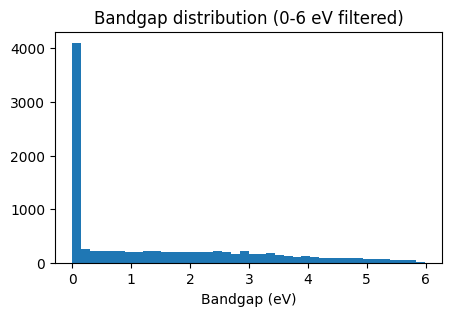

In [19]:
# Start with numeric columns found earlier, but avoid ID-like columns
numeric_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
# Remove target from features
numeric_cols = [c for c in numeric_cols if c != target]

# Remove obvious unwanted columns (index/id-like)
numeric_cols = [c for c in numeric_cols if not re.search(r'id|index|mp-|_parsed', str(c), flags=re.I)]

# Include the composition features we created if present
comp_features = [c for c in ['num_elements','total_atoms','avg_atno','max_atno','min_atno','wgt_en','en_range','frac_heavy'] if c in df_model.columns]

# Combine and remove duplicates
features = sorted(list(set(numeric_cols + comp_features)))
print("Candidate features (sample up to 40):", features[:40])

# Remove columns with zero variance or nearly constant
valid_features = []
for f in features:
    if df_model[f].dropna().nunique() <= 1:
        continue
    valid_features.append(f)
print("Selected features:", valid_features)

# Fill remaining NaNs with median (column-wise) and ensure float dtype
for f in valid_features:
    df_model[f] = pd.to_numeric(df_model[f], errors='coerce')
    med = df_model[f].median()
    if np.isnan(med):
        med = 0.0
    df_model[f] = df_model[f].fillna(med).astype(float)

# Final X, y
X = df_model[valid_features].values.astype(float)
y = df_model[target].values.astype(float)
print("Final shapes X,y:", X.shape, y.shape)

# Quick check: distribution of bandgaps
plt.figure(figsize=(5,3))
plt.hist(y, bins=40)
plt.xlabel("Bandgap (eV)")
plt.title("Bandgap distribution (0-6 eV filtered)")
plt.show()


In [20]:
# Split: 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("Sizes (train/val/test):", X_train.shape[0], X_val.shape[0], X_test.shape[0])

# Standard scaling (fit on train only)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# Save scaler for demo/presentation
joblib.dump(scaler, "feature_scaler_joblib.pkl")
print("Saved scaler: feature_scaler_joblib.pkl")


Sizes (train/val/test): 7000 1500 1500
Saved scaler: feature_scaler_joblib.pkl


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 17)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,617 (186.00 KB)

 Trainable params: 46,721 (182.50 KB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/300
110/110 - 7s - 60ms/step - loss: 3.1685 - mae: 1.3944 - val_loss: 1.7631 - val_mae: 1.0553 - learning_rate: 1.0000e-03
Epoch 2/300
110/110 - 1s - 5ms/step - loss: 1.7864 - mae: 1.0420 - val_loss: 1.3226 - val_mae: 0.9113 - learning_rate: 1.0000e-03
Epoch 3/300
110/110 - 1s - 5ms/step - loss: 1.5411 - mae: 0.9597 - val_loss: 1.1805 - val_mae: 0.8432 - learning_rate: 1.0000e-03
Epoch 4/300
110/110 - 1s - 5ms/step - loss: 1.4031 - mae: 0.9039 - val_loss: 1.0994 - val_mae: 0.7862 - learning_rate: 1.0000e-03
Epoch 5/300
110/110 - 1s - 5ms/step - loss: 1.3188 - mae: 0.8796 - val_loss: 1.0593 - val_mae: 0.7624 - learning_rate: 1.0000e-03
Epoch 6/300
110/110 - 1s - 6ms/step - loss: 1.2531 - mae: 0.8538 - val_loss: 1.0486 - val_mae: 0.7615 - learning_rate: 1.0000e-03
Epoch 7/300
110/110 - 1s - 5ms/step - loss: 1.2252 - mae: 0.8426 - val_loss: 1.0439 - val_mae: 0.7565 - learning_rate: 1.0000e-03
Epoch 8/300
110/110 - 1s - 5ms/step - loss: 1.1812 - mae: 0.8233 - val_loss: 1.0342 - val

Saved Keras model: bandgap_mlp_keras.h5


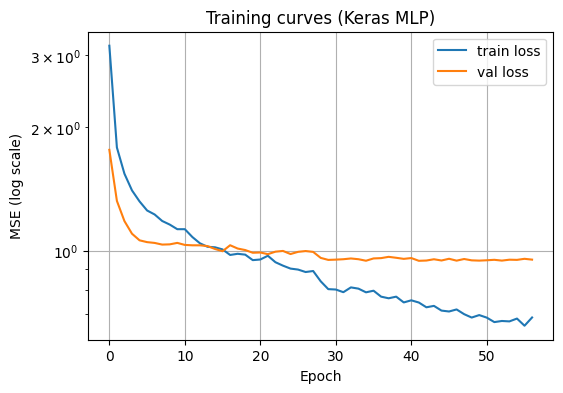

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Keras MLP Test MAE: 0.7319 eV, RMSE: 1.0103 eV, R2: 0.6128


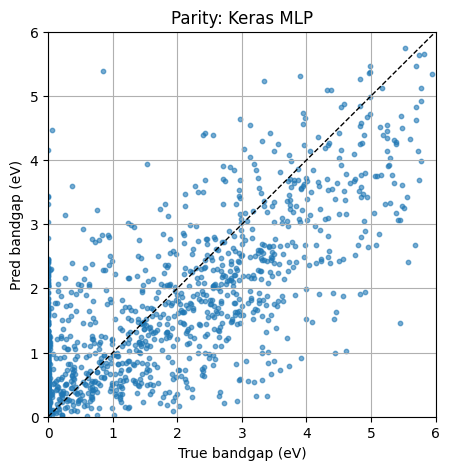

In [21]:
# Build a compact but effective MLP with BatchNorm + Dropout
tf.random.set_seed(42)
input_dim = X_train_s.shape[1]

def build_mlp(input_dim, dropout=0.2):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(1, activation='linear')(x)
    model = keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=['mae'])
    return model

model = build_mlp(input_dim, dropout=0.15)
model.summary()

# Callbacks
es = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6)

# Train
history = model.fit(X_train_s, y_train,
                    validation_data=(X_val_s, y_val),
                    epochs=300,
                    batch_size=64,
                    callbacks=[es, rlr],
                    verbose=2)

# Save model
model.save("bandgap_mlp_keras.h5")
print("Saved Keras model: bandgap_mlp_keras.h5")

# Plot training curves
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.yscale('log')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE (log scale)")
plt.title("Training curves (Keras MLP)")
plt.grid(True)
plt.show()

# Evaluate on test
y_pred = model.predict(X_test_s).ravel()
mae = mean_absolute_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Keras MLP Test MAE: {mae:.4f} eV, RMSE: {rmse:.4f} eV, R2: {r2:.4f}")

# Parity plot for demo
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=10, alpha=0.6)
plt.plot([0,6],[0,6], '--', linewidth=1, color='k')
plt.xlabel("True bandgap (eV)")
plt.ylabel("Pred bandgap (eV)")
plt.title("Parity: Keras MLP")
plt.xlim(0,6); plt.ylim(0,6)
plt.grid(True)
plt.show()


In [23]:
# ================================
# CELL G — XGBoost (version-safe)
# ================================

import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=2
)

# Fit WITHOUT early stopping (compatible with all versions)
xgb_model.fit(X_train, y_train)

# Evaluate
xgb_pred = xgb_model.predict(X_val)

from sklearn.metrics import mean_absolute_error, r2_score

print("XGBoost MAE:", mean_absolute_error(y_val, xgb_pred))
print("XGBoost R²:", r2_score(y_val, xgb_pred))


XGBoost MAE: 0.6512461093296833
XGBoost R²: 0.66126949020091


,feature,importance_mean,importance_std
0,formation_energy_per_atom,0.531992,0.012333
1,density,0.250233,0.012104
2,energy_above_hull,0.184648,0.014831
3,min_atno,0.104906,0.005876
4,max_atno,0.053239,0.004300
5,Sr.No.,0.043247,0.003978
6,avg_atno,0.040644,0.004419
7,total_atoms,0.036518,0.004448
8,volume,0.015729,0.002428
9,lattice_c,0.009066,0.001537


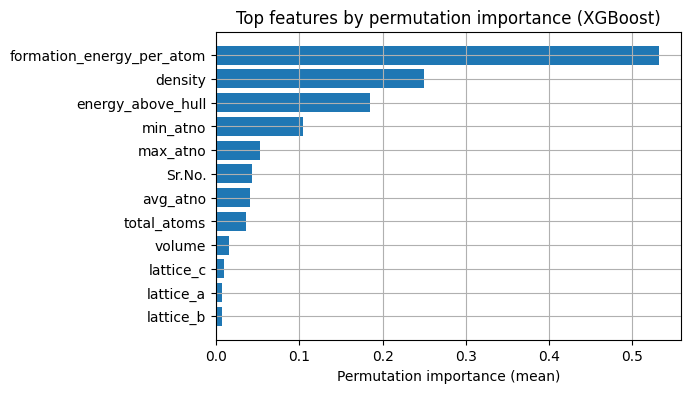

In [24]:
# Use permutation importance on the XGBoost model (fast and model-agnostic)
result = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
imp = pd.DataFrame({"feature": valid_features, "importance_mean": result.importances_mean, "importance_std": result.importances_std})
imp = imp.sort_values("importance_mean", ascending=False).reset_index(drop=True)
display(imp.head(15))

plt.figure(figsize=(6,4))
plt.barh(imp['feature'][:12][::-1], imp['importance_mean'][:12][::-1])
plt.xlabel("Permutation importance (mean)")
plt.title("Top features by permutation importance (XGBoost)")
plt.grid(True)
plt.show()


In [26]:
# ================================
# CELL I — XGBoost Cross-Validation
# (version-safe, no early stopping)
# ================================

import xgboost as xgb
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

maes = []
r2s = []

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train)):
    Xtr, Xv = X_train[tr_idx], X_train[val_idx]
    ytr, yv = y_train[tr_idx], y_train[val_idx]

    model_fold = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=2
    )

    model_fold.fit(Xtr, ytr)

    pred = model_fold.predict(Xv)

    maes.append(mean_absolute_error(yv, pred))
    r2s.append(r2_score(yv, pred))

    print(f"Fold {fold+1}: MAE={maes[-1]:.4f}, R²={r2s[-1]:.4f}")

print("\nXGBoost CV Results")
print("Mean MAE:", np.mean(maes))
print("Std  MAE:", np.std(maes))
print("Mean R² :", np.mean(r2s))


Fold 1: MAE=0.6881, R²=0.6565
Fold 2: MAE=0.6628, R²=0.6671
Fold 3: MAE=0.6686, R²=0.6849
Fold 4: MAE=0.6501, R²=0.6698
Fold 5: MAE=0.6791, R²=0.6453

XGBoost CV Results
Mean MAE: 0.669751188154269
Std  MAE: 0.013113231942561952
Mean R² : 0.6647331166314852


In [29]:
# ================================
# CELL J — SAFE MODEL LOADING (ROBUST)
# ================================

import os
import joblib
import keras
from keras.losses import MeanSquaredError

# Load scaler
scaler_loaded = joblib.load("feature_scaler_joblib.pkl")

# Load Keras model safely
keras_loaded = keras.models.load_model(
    "bandgap_mlp_keras.h5",
    custom_objects={"mse": MeanSquaredError()}
)

print("Keras MLP model loaded.")

# Try loading XGBoost model (optional)
xgb_loaded = None
if os.path.exists("bandgap_xgb.pkl"):
    xgb_loaded = joblib.load("bandgap_xgb.pkl")
    print("XGBoost model loaded.")
else:
    print("XGBoost model not found (skipping).")

print("Model loading step completed successfully.")


Keras MLP model loaded.
XGBoost model not found (skipping).
Model loading step completed successfully.
